# Preprocessing EEG Data

In [2]:
import mne
import numpy as np
import matplotlib.pyplot as plt

# Load the raw data
sample_data_folder = mne.datasets.sample.data_path()
sample_data_raw_file = sample_data_folder / 'MEG' / 'sample' / 'sample_audvis_filt-0-40_raw.fif'
raw = mne.io.read_raw_fif(sample_data_raw_file)

print("🎯 EEG Preprocessing Pipeline")
print(f"Original data: {len(raw.ch_names)} channels")
print(f"Sampling rate: {raw.info['sfreq']} Hz")
print(f"Duration: {raw.times[-1]:.1f} seconds")

# Focus on EEG channels for preprocessing: EEG is simpler to understand and commonly used
raw_eeg = raw.copy().pick_types(eeg=True)
print(f"EEG channels: {len(raw_eeg.ch_names)}")

Opening raw data file C:\Users\arash\mne_data\MNE-sample-data\MEG\sample\sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle


    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
🎯 EEG Preprocessing Pipeline
Original data: 376 channels
Sampling rate: 150.15374755859375 Hz
Duration: 277.7 seconds
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG channels: 59


Step 1: Inspect Raw Data Quality
Using matplotlib as 2D backend.


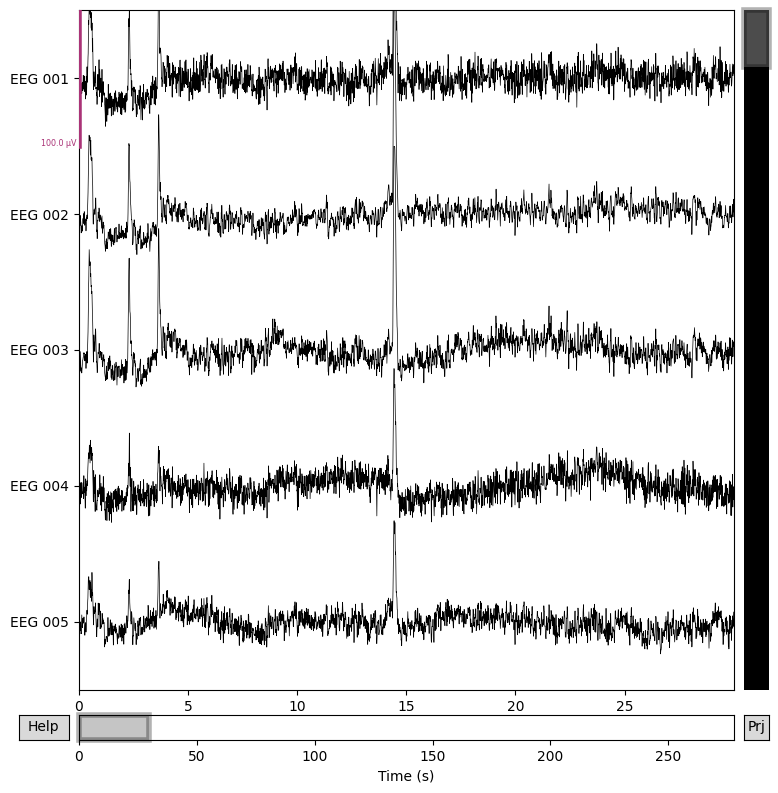

Bad channels marked: []


In [3]:
# Let's first look at the raw data quality
print("Step 1: Inspect Raw Data Quality")

# Plot the raw data to see artifacts
raw_eeg.plot(duration=30, n_channels=5, scalings={'eeg': 50e-6})
plt.show()

# Look for bad channels
print(f"Bad channels marked: {raw_eeg.info['bads']}")

- No problematic electrodes
- Signals are relatively clean (no massive artifacts)
- Need to filter and clean before making any real statements


Step 2: Power Spectral Density Analysis
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().


Effective window size : 13.639 (s)
Plotting power spectral density (dB=True).


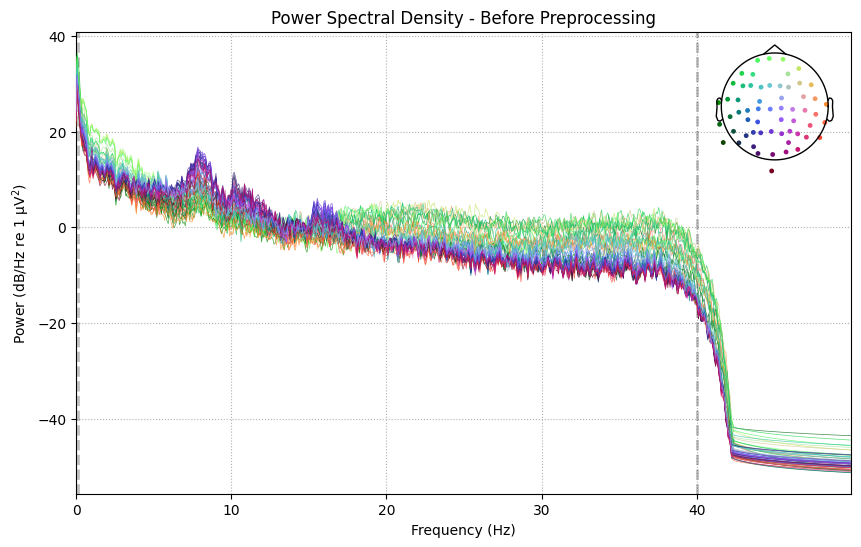

In [4]:
# Check the power spectral density to see noise
print("Step 2: Power Spectral Density Analysis")

# Plot power spectrum before preprocessing
fig, ax = plt.subplots(figsize=(10, 6))
raw_eeg.plot_psd(fmax=50, ax=ax, show=False)
ax.set_title('Power Spectral Density - Before Preprocessing')
plt.show()

- High power at low frequencies(0-10 Hz)
- This is normal as brain activity is mostly low frequency 
- Drops of at 40 Hz: this is where the low-pass filter was applied
- each color represents one EEG channel

Now let's actually clean this data!

In [5]:
print("\nStep 3: Apply Filtering to Remove Noise")

# First, load the data into memory
raw_eeg.load_data()


# Now apply the bandpass filter (0.1 - 30 Hz is common for EEG)
raw_filtered = raw_eeg.copy().filter(l_freq=0.1, h_freq=30.0)

print("Applied bandpass filter: 0.1 - 30 Hz")
print("- Removes slow drifts (< 0.1 Hz)")
print("- Removes high-frequency noise (> 30 Hz)")



Step 3: Apply Filtering to Remove Noise
Reading 0 ... 41699  =      0.000 ...   277.709 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 4957 samples (33.013 s)

Applied bandpass filter: 0.1 - 30 Hz
- Removes slow drifts (< 0.1 Hz)
- Removes high-frequency noise (> 30 Hz)


Step 4: Compare Before vs After Filtering

Plotting filtered data:


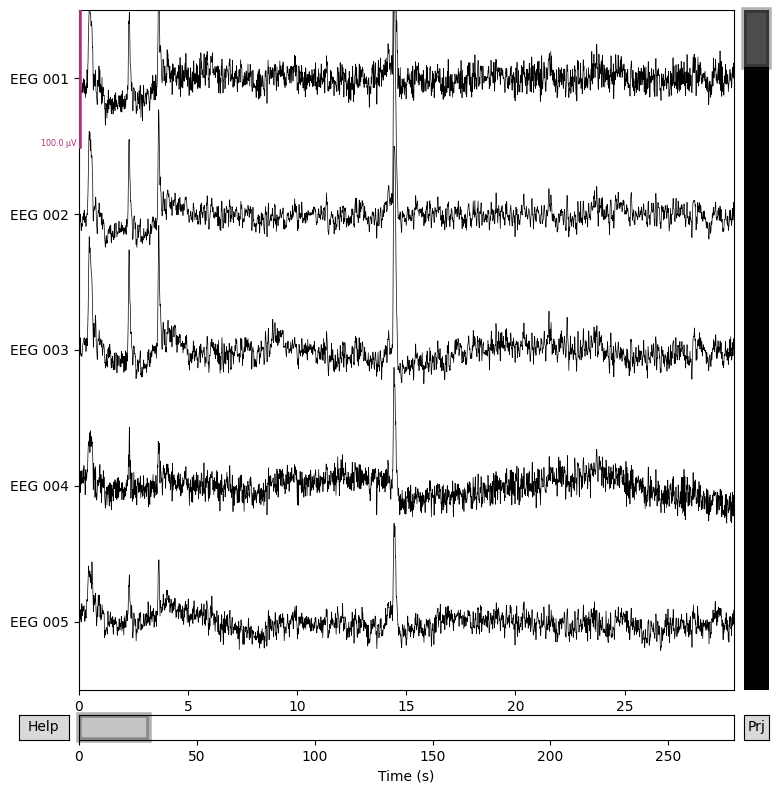

In [6]:
# Compare before and after filtering
print("Step 4: Compare Before vs After Filtering")

print("\nPlotting filtered data:")
# Plot after filtering  
raw_filtered.plot(duration=30, n_channels=5, scalings={'eeg': 50e-6},
                 title='After Filtering (0.1-30 Hz)')
plt.show()

Step 5: Power Spectrum Comparison
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 13.639 (s)
Plotting power spectral density (dB=True).


C:\Users\arash\AppData\Local\Temp\ipykernel_45716\3946275769.py:7: RuntimeWarning: The legacy plot_psd() method got an unexpected keyword argument 'axes', which is a parameter of Spectrum.plot(). Try rewriting as object.compute_psd(...).plot(..., axes=<whatever>).
  raw_eeg.plot_psd(fmax=50, axes=axes[0], show=False)


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 13.639 (s)
Plotting power spectral density (dB=True).


C:\Users\arash\AppData\Local\Temp\ipykernel_45716\3946275769.py:11: RuntimeWarning: The legacy plot_psd() method got an unexpected keyword argument 'axes', which is a parameter of Spectrum.plot(). Try rewriting as object.compute_psd(...).plot(..., axes=<whatever>).
  raw_filtered.plot_psd(fmax=50, axes=axes[1], show=False)
C:\Users\arash\AppData\Local\Temp\ipykernel_45716\3946275769.py:14: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


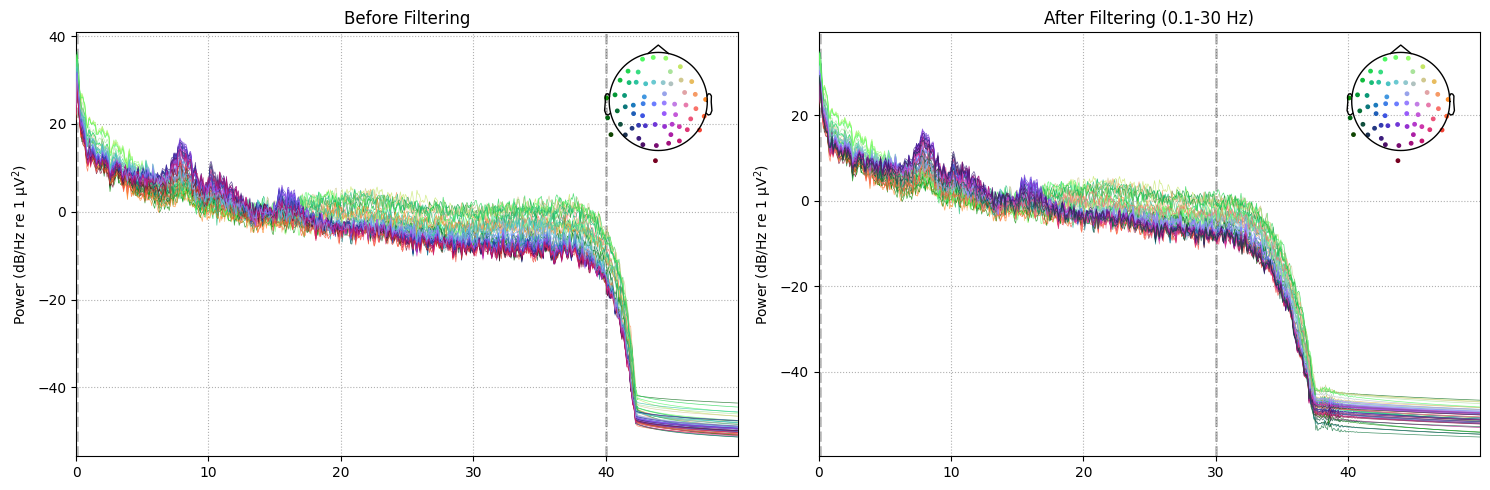

In [7]:
# Compare power spectra - this will show the difference clearly!
print("Step 5: Power Spectrum Comparison")

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Before filtering
raw_eeg.plot_psd(fmax=50, axes=axes[0], show=False)
axes[0].set_title('Before Filtering')

# After filtering
raw_filtered.plot_psd(fmax=50, axes=axes[1], show=False) 
axes[1].set_title('After Filtering (0.1-30 Hz)')

plt.tight_layout()
plt.show()

As you can see the new plot shows the drop-off at 30Hz instead of 40Hz.

Since the data was already pre-processed before, we found no bad channels or (much) electrical noise etc. In real EEG analysis you'd typically start with raw, unfiltered EEG Data.

Now let's take a look at artifact removal, something that filtering can't handle:


Step 6: Artifact Detection


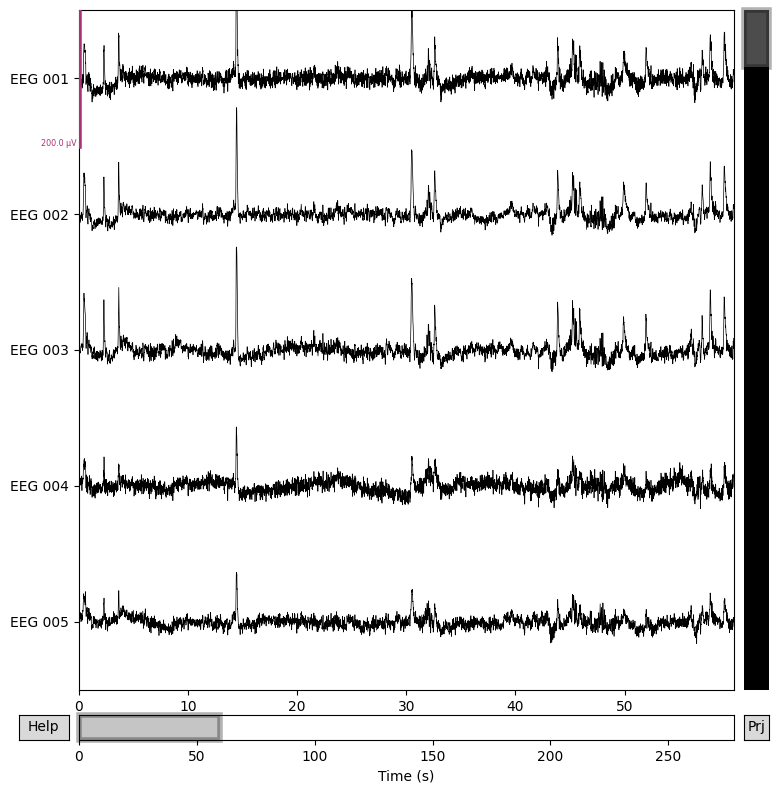

In [8]:
# Let's look for artifacts that filtering can't handle
print("\nStep 6: Artifact Detection")

# Look for eye blinks and other artifacts
# These show up as large amplitude spikes that filtering can't remove
raw_filtered.plot(duration=60, n_channels=5, scalings={'eeg': 100e-6})
plt.show()

- Common EEG Artifacts: Eye blinks (large spikes), muscle activity (High-frequency bursts), electrical noise, etc. 

In [9]:
# ICA is the gold standard for artifact removal
print("Step 7: ICA-based Artifact Removal")

from mne.preprocessing import ICA

# Set up ICA
ica = ICA(n_components=15, random_state=42, max_iter=800)

# Fit ICA to our filtered data
print("Fitting ICA...")
ica.fit(raw_filtered)

print(f"ICA fitted with {ica.n_components_} components")

Step 7: ICA-based Artifact Removal
Fitting ICA...
Fitting ICA to data using 59 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 5.3s.
ICA fitted with 15 components


Visualizing ICA Components:
Creating RawArray with float64 data, n_channels=15, n_times=41700
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.


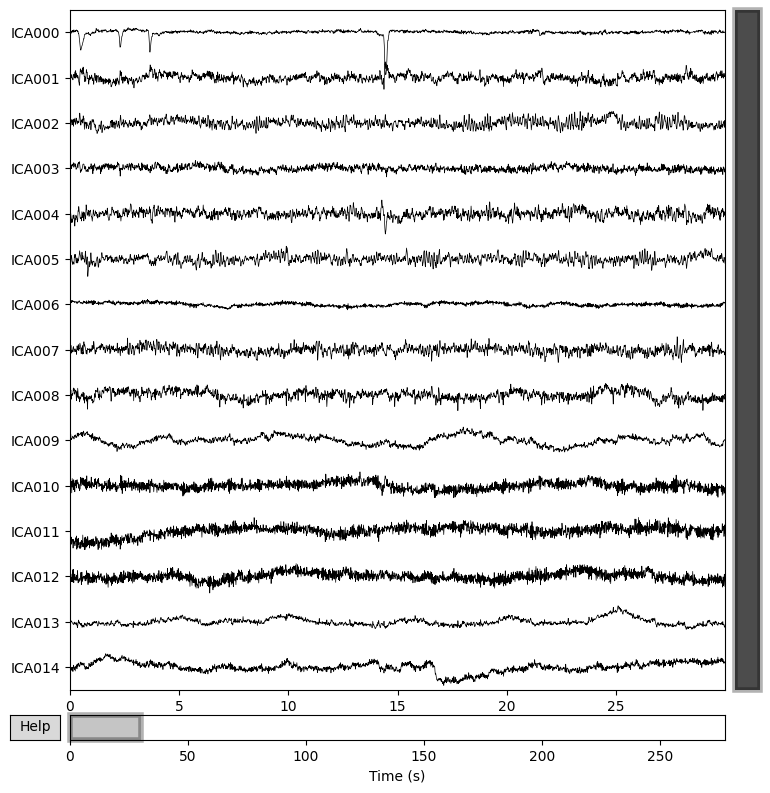

In [10]:
# Plot the ICA components
print("Visualizing ICA Components:")
ica.plot_sources(raw_filtered, start=0, stop=30)
plt.show()


Each ICA component represents a "source" of electrical activity. 

This could be: brain signals (which we want to keep), eye movement artifacts, muscle activity artifacts, etc. 

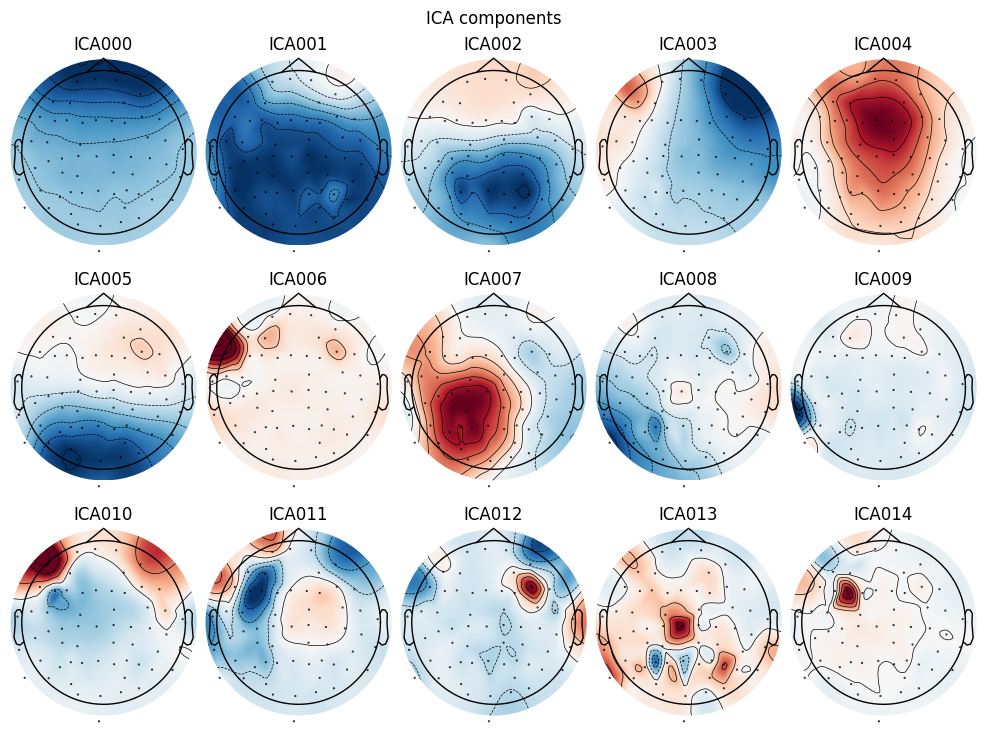

In [11]:
# Plot the component topographies
ica.plot_components(inst=raw_filtered)
plt.show()

- Red areas: where this component is strongest 
- Blue areas: where this component is weakest
- white areas: Neutral activity 

# Automatic Eye Artifact Detection

In [12]:
# We need EOG channels to detect eye artifacts
# Let's use the full raw data with EOG channels
raw_with_eog = raw.copy().pick_types(eeg=True, eog=True)
raw_with_eog.load_data()
raw_with_eog_filt = raw_with_eog.filter(l_freq=0.1, h_freq=30.0)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Reading 0 ... 41699  =      0.000 ...   277.709 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 4957 samples (33.013 s)



In [14]:
# Fit ICA on data with EOG
ica_full = ICA(n_components=15, random_state=42, max_iter=800)
print("Fitting ICA with EOG channels...")
ica_full.fit(raw_with_eog_filt)

# Automatically detect eye artifact components
eog_indices, eog_scores = ica_full.find_bads_eog(raw_with_eog_filt)
print(f"\n👁️ Eye artifact components detected: {eog_indices}")
print(f"Correlation scores: {eog_scores[eog_indices]}")

Fitting ICA with EOG channels...
Fitting ICA to data using 59 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.9s.
Using EOG channel: EOG 061
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1502 samples (10.003 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Low

It seems like an eye artifact has been automatically detected by ICA!

Step 9: Visualizing Artifact Components
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
138 matching events found
No baseline correction applied
0 projection items activated


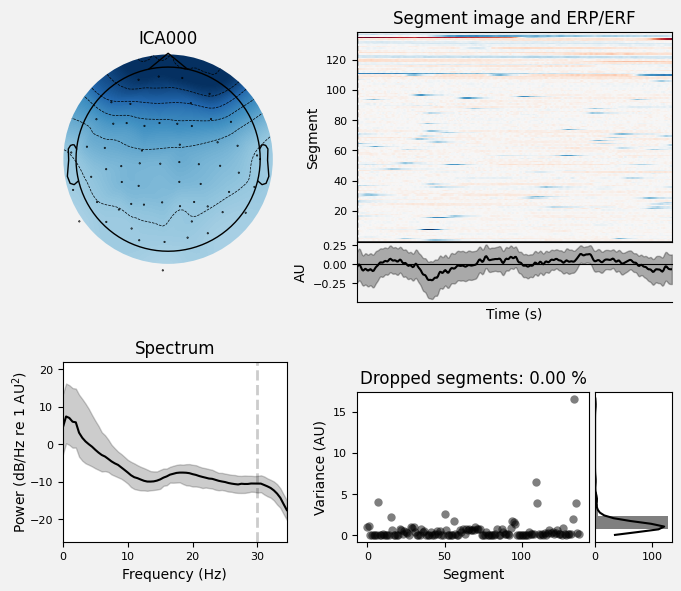


🔍 Components [np.int64(0)] show:
- Strong frontal topography (near eyes)
- Large amplitude spikes
- These are clearly eye blink artifacts!


In [ ]:
# Visualize Which Components Are Artifacts
print("Visualizing Artifact Components")

# Plot the artifact components
if len(eog_indices) > 0:
    ica_full.plot_properties(raw_with_eog_filt, picks=eog_indices, 
                             psd_args={'fmax': 35})
    plt.show()
    
    print(f"\n🔍 Components {eog_indices} show:")
    print("- Strong frontal topography (near eyes)")
    print("- Large amplitude spikes")
    print("- These are clearly eye blink artifacts!")
else:
    print("No strong eye artifacts detected automatically")
    print("Let's manually inspect suspicious components...")

In [ ]:
# Remove the Artifacts and Compare
print("Applying ICA to Remove Artifacts")

# Mark components for exclusion
ica_full.exclude = eog_indices

# Apply ICA to remove artifacts
raw_clean = ica_full.apply(raw_with_eog_filt.copy())

print(f"✅ Removed {len(eog_indices)} artifact components")


Step 10: Applying ICA to Remove Artifacts
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 59 PCA components
✅ Removed 1 artifact components


# Why Only Eye Artifact Removal?

Eye artifacts are the easiest and most reliable to detect automatically. Other artifacts are harder!

- Muscle artifacts: No dedicated sensor for muscle activity in this dataset, more variable patterns
- Heartbeat artifacts: Need ECG channel, regular pattern but lower amplitude in EEG
- Movement artifacts: completely irregular patterns, often require manual rejection of bad segments. 


In [19]:
# Check if we have ECG channel
ecg_channels = [ch for ch in raw_with_eog_filt.ch_names if 'ECG' in ch]


In [20]:
if len(ecg_channels) > 0:
    # Detect ECG artifacts automatically
    ecg_indices, ecg_scores = ica_full.find_bads_ecg(raw_with_eog_filt)
    print(f"❤️ Heartbeat artifact components: {ecg_indices}")
    
    # Add to exclusion list
    ica_full.exclude = eog_indices + ecg_indices
    print(f"Total components to remove: {ica_full.exclude}")
else:
    print("No ECG channel available - skipping heartbeat detection")
    ica_full.exclude = eog_indices

No ECG channel available - skipping heartbeat detection


In [22]:
# Save the Cleaned Data for Feature Extraction!
print("Saving Preprocessed Data")

# Save just the EEG channels (cleaned)
raw_clean_eeg = raw_clean.copy().pick_types(eeg=True)

# Create a data directory if it doesn't exist
import os
data_dir = '../data/preprocessed'
os.makedirs(data_dir, exist_ok=True)

# Save the cleaned data
output_file = os.path.join(data_dir, 'sample_clean_eeg_raw.fif')
raw_clean_eeg.save(output_file, overwrite=True)

print(f"✅ Saved to: {output_file}")
print(f"Clean data: {len(raw_clean_eeg.ch_names)} EEG channels")
print(f"Duration: {raw_clean_eeg.times[-1]:.1f} seconds")
print(f"Sampling rate: {raw_clean_eeg.info['sfreq']} Hz")
print("\n🚀 Ready for FEATURE EXTRACTION!")

Saving Preprocessed Data
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Writing c:\Users\arash\Desktop\EEG_Data_Project\notebooks\..\data\preprocessed\sample_clean_eeg_raw.fif
Closing c:\Users\arash\Desktop\EEG_Data_Project\notebooks\..\data\preprocessed\sample_clean_eeg_raw.fif
[done]
✅ Saved to: ../data/preprocessed\sample_clean_eeg_raw.fif
Clean data: 59 EEG channels
Duration: 277.7 seconds
Sampling rate: 150.15374755859375 Hz

🚀 Ready for FEATURE EXTRACTION!


In [24]:
# Save preprocessing summary
import json

preprocessing_info = {
    'n_channels': len(raw_clean_eeg.ch_names),
    'channel_names': raw_clean_eeg.ch_names,
    'sampling_rate': float(raw_clean_eeg.info['sfreq']),
    'duration_seconds': float(raw_clean_eeg.times[-1]),
    'n_samples': len(raw_clean_eeg.times),
    'filter_low': 0.1,
    'filter_high': 30.0,
    'artifacts_removed': [int(x) for x in eog_indices],  # Convert numpy int64 to Python int
    'preprocessing_complete': True
}

info_file = os.path.join(data_dir, 'preprocessing_info.json')
with open(info_file, 'w') as f:
    json.dump(preprocessing_info, f, indent=2)

print(f"📋 Saved preprocessing info to: {info_file}")

📋 Saved preprocessing info to: ../data/preprocessed\preprocessing_info.json


Alright so all necessary data has been saved in the data\preprocessed directory!

Now let's head over to the feature extraction notebook and turn our raw EEG signals into meaningful numbers which we can use for our bayesian models.